# Finetuning CNNs on medical image data

The objective of this homework is to use deep learning to recognize tumors in tissue image. We will use the [PCAM](https://github.com/basveeling/pcam) dataset consisting of "327.680 color images (96 x 96px) extracted from histopathologic scans of lymph node sections".

**Note:** This homework will require intensive computations. It is thus preferable to use GPUs, for example with Google Colab (free access to GPUs).

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets
import time
from tqdm import tqdm,trange

Check if GPU is available and if not change the [runtime](https://jovianlin.io/pytorch-with-gpu-in-google-colab/).

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


## Data preprocessing

First, download the PCAM dataset using torchvision (see [documentation](https://pytorch.org/vision/stable/generated/torchvision.datasets.PCAM.html#torchvision.datasets.PCAM)). To keep computation times low, we will use the validation set (parameter `split='val'`) as train set (variable name `data_train`), and the test set (parameter `split='test'`) as test (variable name `data_test`). Plot the first 5 images of the train set corresponding to a tumor and the 5 first corresponding to healthy tissue. Can you see a difference?

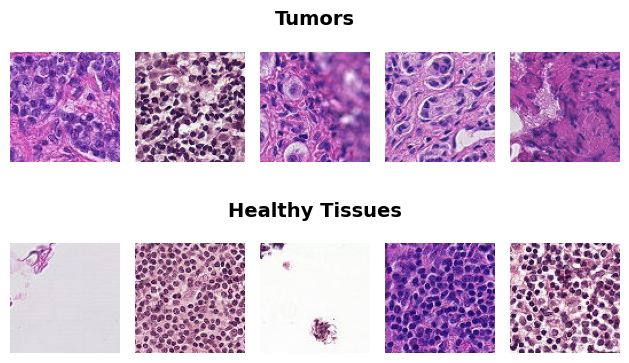

In [57]:
# download dataset
data_train = datasets.PCAM("./", split = 'val', download= True)
data_test = datasets.PCAM("./", split = 'test', download = True)

# get the first five images corresponding to a tumor or healthy tissue
tumor_images = []
healthy_images = []
for img, label in data_train:
  if label == 1 and len(tumor_images) < 5:
    tumor_images.append(img)
  if label == 0 and len(healthy_images) < 5:
    healthy_images.append(img)
  if len(tumor_images) == 5 and len(healthy_images) == 5:
    break

# Plot the images in a 2X5 grid. First row for tumor images and second for healthy tissues
fig,axes = plt.subplots(2,5)

for j in range(5):
  axes[0,j].imshow(tumor_images[j])
  axes[0,j].axis('off')

for j in range(5):
  axes[1,j].imshow(healthy_images[j])
  axes[1,j].axis('off')

fig.text(0.5, 0.87, 'Tumors', ha='center', fontsize=14, weight='bold')
fig.text(0.5, 0.47, 'Healthy Tissues', ha='center', fontsize=14, weight='bold')


plt.tight_layout()
plt.show()


Use `data_train.transform` and `data_test.transform` (see the [documentation](https://pytorch.org/vision/0.9/transforms.html)) to turn the images into tensors (of shape (3,96,96)) and normalize them using `transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`, and verify that your data has the correct shape. How many elements are in your train and test sets?

In [61]:
# define the transformation
tfs = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_train.transform = tfs
data_test.transform = tfs

print(f"No. of images in data_train: {len(data_train)} \n Shape of images: {data_train[0][0].shape}")
print(f"No. of images in data_test: {len(data_test)} \n Shape of images: {data_test[0][0].shape}")



No. of images in data_train: 32768 
 Shape of images: torch.Size([3, 96, 96])
No. of images in data_test: 32768 
 Shape of images: torch.Size([3, 96, 96])


Now create a train and a test dataloader with a batch size of 64, and a random permutation for the train dataloader (with `shuffle=True`). How many mini-batches do you have?

In [63]:
# creat dataloaders for train and test data
from torch.utils.data.dataloader import DataLoader
train_dataloader = DataLoader(data_train, batch_size=64, shuffle=True) #512 minibatches
test_dataloader = DataLoader(data_test, batch_size=64, shuffle=True) #512 minibatches

## Training and testing loop

Write a function `train_model(model, dataloader, epochs)` that performs `epochs` training epochs using the Adam optimizer (with learning rate $10^{-3}$) on the cross entropy loss (using `nn.CrossEntropyLoss()`) for the model and data provided as input. **Note:** Remember to set the model to training mode using `model.train()`, and put the model and tensors on the correct device (CPU or GPU) by using `x.to(device)`. Plot the loss and accuracy of the model over the train set at each epoch.

In [67]:
# function to train a model given a dataloader and number of epochs
def train_model(model, dataloader, epochs):
  # Adam optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
  loss_function = nn.CrossEntropyLoss()
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model.to(device)

  for epoch in trange(1, epochs + 1, desc="Epoch"):
    model.train()
    t_loss = 0
    for i,(imgs, labels) in enumerate(tqdm(train_dataloader)):
      imgs.to(device)
      labels.to(device)

      optimizer.zero_grad()

      # evaluate the model on this minibatch
      output = model(imgs)

      loss = loss_function(output, labels)
      t_loss += loss

      loss.backward()

      optimizer.step()
    # get accuracy for this epoch
    acc = 0
    with torch.no_grad():
      labels_output = model(torch.Tensor([img for img,_ in data_train])).argmax(axes = 1)
      print(f"Epoch {epoch} training accuracy={(labels_output == [label for _,label in data_train]).float().mean().item():.3f} / Loss = {t_loss}")





Now write a function `test_model(model,dataloader)` that plots the loss and accuracy of the model on the whole dataset.

In [ ]:
#
# YOUR CODE HERE
#

## Training a linear model

We now test a baseline model on our classification task: a simple linear model. Create a model using `nn.Sequential` that takes images, flatten them into vectors, and then compute a linear model out of it. The output should be 2-dimensional (to match our 2 classes). Then, train it for 2 epochs and test it on the test dataset.

In [ ]:
%%time
#
# YOUR CODE HERE
#

## Fine-tuning a CNN model

We are now going to fine-tune a VGG model trained on [ImageNet](http://www.image-net.org/) (1.2M training images). The torchvision module comes with a zoo of pretrained popular CNN architectures. When called the first time, if `pretrained=True` the model is fetched over the internet and downloaded to `~/.torch/models`. For next calls, the model will be directly read from there.

First, load the VGG model using `models.vgg16(weights='DEFAULT')` and print it to see its architecture.

In [ ]:
#
# YOUR CODE HERE
#

Note that the model is divided into two part: a **feature** section mainly made of convolutions and pooling layers, and a **classifier** part made of an MLP. We'll learn about what these different blocks do later in the course. For now, it's enough to know that:

- Convolution layers are for finding small to medium size patterns in images -- analyzing the images locally
- Dense (fully connected) layers are for combining patterns across an image -- analyzing the images globally
- Pooling layers downsample -- in order to reduce image size and to improve invariance of learned features

The idea of fine-tuning is that the features computed by VGG for Imagenet may be also good for other applications (e.g. for medical images). Replace the last layer of the `model_vgg.classifier` by a new linear layer that outputs 2 values (one for each class), and **freeze** all the other parameters of the VGG model by using `parameter.requires_grad=False` on all the parameters of the model except for the last layer.

In [ ]:
#
# YOUR CODE HERE
#

Now fine-tune the model by performing 2 epochs of training.

In [ ]:
%%time
#
# YOUR CODE HERE
#

## Speeding-up training by precomputing features

We are wasting a lot of time computing over and over the same quantities. Indeed, the first part of the VGG model (called `features` and made of convolutional layers) is frozen and never updated. Hence, we can precompute for each image in the dataset, the output of these convolutional layers as these outputs will always be the same during your training process.

Write a function `precompute_model(model, dataloader)` that takes a model and a dataloader as input, and returns a dataset containing the outputs of the model as input using `torch.utils.data.TensorData`.

In [ ]:
#
# YOUR CODE HERE
#

Use `precompute_model` to create a DataLoader for the train and test dataset with precomputed VGG features.

In [ ]:
%%time
#
# YOUR CODE HERE
#

Finally, train a linear model on the our new precomputed features for 50 epochs. Is the model better?

In [ ]:
%%time
#
# YOUR CODE HERE
#